In [1]:
import numpy as np
from matplotlib import pyplot as plt
import itertools
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

In [2]:
### data generation

np.random.seed(1600)

# returns Gaussian data centered at origin
def generate_gaussian(d, width, num_samples):
    return np.random.multivariate_normal(np.zeros(d), np.identity(d) * width, num_samples)

def generate_cube(d, width, num_samples):
#     data = []
#     ran = np.linspace(-width, width, num_per_dim)
#     for point in itertools.product(ran, repeat = d):
#         data.append(point)
#     return np.array(data)
    data = []
    while len(data) < num_samples:
        point = np.random.normal(0,1,d)
        if np.max(point) < 1 and np.min(point) > -1:
            data.append(point)
    return np.array(data * width)

#generate spheres on vertices of d-dimensional simplex
def generate_spheres(d, k, width, num_samples):
    k = int(num_samples / d)
    centers = []
    for i in range(d):
        point = np.zeros(d)
        point[i] = 5
        centers.append(point)
    data = []
    for center in centers:
        for i in range(k):
            s = sphere(k)
            point = center.copy()
            point[:k] += s
            data.append(point)
    return np.array(data)
    
def sphere(d):
    u = np.random.normal(0,1,d)  # an array of d normally distributed random variables
    d = np.linalg.norm(u)
    return u/d

def get_pairwise_distances(X):
    return squareform(pdist(X, 'euclidean'))

def get_pairwise_sq_distances(X):
    return squareform(pdist(X, 'sqeuclidean'))

def distance(x,y):
    return np.linalg.norm(x - y)


In [3]:
def dim_estimate(X, k1, k2):
    n = X.shape[0]
    D = get_pairwise_distances(X)
    estimates = []
    m_hat = []
    #for every point, find the local estimate
    for k in range(k1, k2):
        m = []
        for i in range(n):
            neigh_indices = np.argsort(D[i])[1:k+1]
            m.append(local(X, neigh_indices, i, k))
        m_hat.append(1 / np.average(np.reciprocal(m)))
    return 1 / (k2 - k1 + 1) * np.sum(m_hat)
        
def local(X, neigh_indices, i, k):
    s = 0
    for j in range(k):
        s += np.log(distance(X[i], X[neigh_indices[-1]]) / distance(X[i], X[neigh_indices[j]]))
    return (1 / (k-1) * s)**-1
    
def jl(X, m, epsilon = 0.5, num_trials = 10):
    n = X.shape[0]
    d = X.shape[1]
    results = []
    A = np.zeros((d,m))
    for k in range(num_trials):
        print(k)
        for i in range(d):
            for j in range(m):
                A[i,j] = np.random.normal()
        A = A * 1/m
        results += loss(X, X@A, 1)#np.sqrt(m/d))
    return results
#     for i in range(d):
#         for j in range(m):
#             A[i,j] = np.random.normal(0, 1/d)
#     return X @ A

#define loss as the maximum distortion of any pair of distances
def loss(X, B, const):
    n = X.shape[0]
    original_distances = get_pairwise_sq_distances(X)
    embedded_distances = get_pairwise_sq_distances(B)
    for i in range(n):
        original_distances[i,i] = 1
    M = embedded_distances / original_distances * const
    for i in range(n):
        M[i,i] = 1
    loss = []
    for i in range(n):
        for j in range(i+1, n):
            loss.append(M[i,j])
    return loss
    

def validate(X, A, epsilon):
    n = X.shape[0]
    original_distances = np.square(get_pairwise_distances(X))
    embedded_distances = np.square(get_pairwise_distances(A))
    M = embedded_distances / original_distances
    for i in range(n):
        M[i,i] = 1
    print(M)
    for i in range(n):
        for j in range(i, n):
            if M[i,j] > 1 + epsilon or M[i,j] < 1 - epsilon:
                return False
    return True

In [6]:
d = 500
k = 50
n = 5000
m_ = [10,25,50,75,100,200,300]
data = generate_spheres(d, k, 1, n)
results = []
for m in m_:
    results.append(jl(data, m))

In [5]:
stderror = np.genfromtxt('concentration.csv', delimiter=',')
stderror2 = np.genfromtxt('concentration_sqrt.csv', delimiter=',')

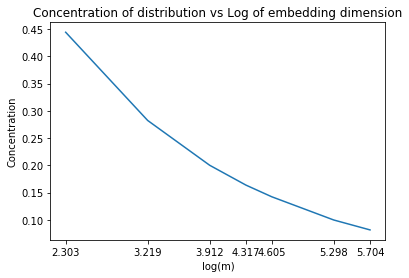

In [8]:
title = "Concentration of distribution vs Log of embedding dimension"
plt.figure()
plt.plot(np.log(m_), stderror)
plt.title(title)
plt.xticks(np.log(m_))
plt.xlabel("log(m)")
plt.ylabel("Concentration")
#plt.show()
plt.savefig("fig/{}.png".format(title.replace(":", "_").replace(" ", "_")), dpi = 400)

In [ ]:
plt.figure(1)
plt.hist(results[0], bins = 100)
plt.show()

In [ ]:
d = 500
k = 50
n = 5000
m = 50
data = generate_spheres(d, k, 1, n)
results = jl(data, m)
# plt.figure()
# plt.scatter(embedded[:,0], embedded[:,1], alpha = 0.4)
# plt.axis('equal')
# plt.show()

plt.figure()
plt.hist(results, bins = 100, density = True)
plt.show()

In [17]:
d = 500
k = 50
n = 5000
e = 50
data = generate_spheres(d, k, 1, n)
results = jl(data, e)
# plt.figure()
# plt.scatter(embedded[:,0], embedded[:,1], alpha = 0.4)
# plt.axis('equal')
# plt.show()

0
1
2
3
4
5
6
7
8
9


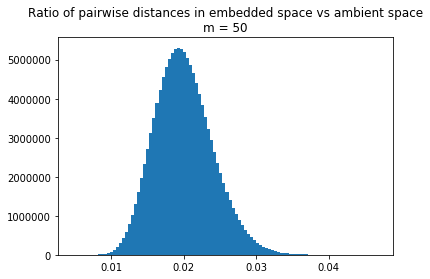

In [18]:
plt.figure()
plt.title("Ratio of pairwise distances in embedded space vs ambient space\nm = {}".format(e))
plt.hist(results, bins = 100)
plt.savefig("fig/bla20.png", dpi = 400)

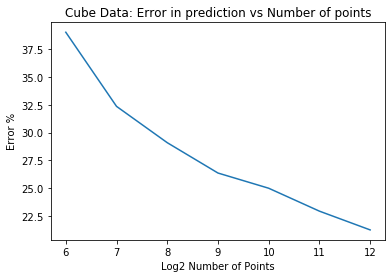

In [221]:
plt.figure()
plt.plot(np.log2(num_points), np.array(results) * 100)
title = "Cube Data: Error in prediction vs Number of points"
plt.title(title)
plt.xticks(np.log2(num_points))
plt.xlabel("Log2 Number of Points")
plt.ylabel("Error %")
#plt.show()
plt.savefig("fig/{}.png".format(title.replace(":", "_").replace(" ", "_")), dpi = 400)